# <i>COM-418 - Computers and Music</i> <br /> <br />  <b>D/A and A/D conversion visualization</b> 

<div align="right"><a href="https://people.epfl.ch/lucie.perrotta">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import scipy.interpolate as interpolate

import import_ipynb
from Helpers import * 

import matplotlib
figsize=(14,10)
matplotlib.rcParams.update({'font.size': 11})
matplotlib.rcParams.update({'lines.linewidth': 3})

importing Jupyter notebook from Helpers.ipynb


In [2]:
fs= 1
T = 1/fs

In this simple notebook, we implement the basic bricks of DAC and an ADC, and we illustrate them with plot examples. In the later notebooks **OneBitMusic** and **QuantizationNoise**, we will use these bricks in concrete examples. But for now, let's already review them independently.

<img width="400" src="pictures/sbq.png">

# 0. Measuring the dB of a digital signal

Before we start, let us clarify how to measure a sound. The decibels measure the power of a sound, but how does that relate to the amplitude of a sound wave? There are mainly 2 ways of deriving that relationship, which lead to different results. 

The first way is by computing the **root mean square (RMS)** value of the signal for each sample. The RMS is obtained by computing the square root of the average of the last $n$ squared samples. RMS metering is generally preferred when we want an accurate representation of the perceived loudness: for a sample amplitude, frequency, and phase, a sine wave is perceived as quieter than a square wave, which translates to a difference of 3dB when using RMS metering.

The second way consists in computing the highest **peak** (the largest absolute amplitude) in the last $n$ samples. It is useful to use peak metering to ensure that the system is never going to clip. A sine wave and a square wave with same amplitude, frequency, and phase, will have the same peak metering value. When working in the digital world, the peak measure is almost exclusively used, and will be the reference for further measures in this class.

In [3]:
def RMS(x, n):
    """
    Compute the RMS of signal x over the last n samples.
    """
    return np.sqrt(np.mean(x[-n:]**2))

def peak(x, n):
    """
    Compute the peak of signal x over the last n samples.
    """
    return np.max(np.abs(x[-n:]))

In [4]:
%%capture
from Synthesizer import sine, square

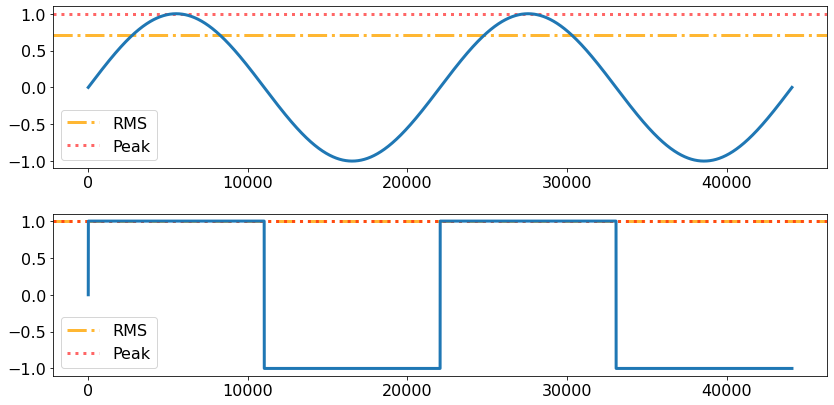

In [5]:
my_sine = sine(1, 4*np.pi, 0, np.linspace(0, 1, 44100))
my_square = square(1, 4*np.pi, 0, np.linspace(0, 1, 44100))

fig, ax = plt.subplots(2, figsize=(12, 6))
fig.tight_layout()

ax[0].axhline(RMS(my_sine, 22050), linestyle="-.", label="RMS", alpha=.8, color="orange")
ax[0].axhline(peak(my_sine, 22050), linestyle="dotted", label="Peak", alpha=.6, color="red")
ax[0].plot(my_sine, alpha=1)

ax[1].axhline(RMS(my_square, 22050), linestyle="-.", label="RMS", alpha=.8, color="orange")
ax[1].axhline(peak(my_square, 22050), linestyle="dotted", label="Peak", alpha=.6, color="red")
ax[1].plot(my_square, alpha=1)

for i in range(2):
    ax[i].legend(loc="lower left")

#plt.savefig("RMS.pdf",bbox_inches='tight')
plt.show()

## 1. Interpolation and sampling

Now we can start. The first thing to worry about when converting a signal from analog to digital and conversly is sampling, resp. quantization. While **sampling** is rather trivial from an algorithmic point of view (simply concatenate the signal values that are spaced by a fixed time in an array), **interpolation** is worth a bit more theory. 

If the highest frequency of the signal is lower than the Nyquist frequency used while sampling, it is theoretically possible to retrieve exactly the original analog signal by interpolating. This is done by fitting a ${\rm sinc}$ function centered on each sample value and by summing all of them together, as
$$
x(t) = \sum_{n=-\infty}^{\infty} x[n] \, {\rm sinc}\left(\frac{t - nT}{T}\right)\
$$
where $T$ is the sampling period, and where
$$
{\rm sinc}(t) = \frac{\sin(\pi t)}{\pi t}.
$$

However, this is not doable in practice as ${\rm sinc}$ functions extend infinitely to the left and the right, making the interpolation computationally very heavy. Instead, we interpolate the signal using finite width functions $interp$ instead of sinc, whose integral over the real numbers is one, as
$$
x(t) = \sum_{n=-\infty}^{\infty} x[n] \, {\rm interp}\left(\frac{t - nT}{T}\right)\ .
$$

Let's implement below the function interp!

In [6]:
def interp(x, t, method):
    """
    Interpolate the discrete signal x into a continuous signal.
    x: the discrete signal to interpolate (a numpy array of floats)
    t: the time where to evaluate the interpolated signal (the ith elem of x is set to be at time i)
    method: the interpolation method, can be "order0", "order1", "order3", or "sinc"
    return: one value of the interpolated signal at time t
    """
    i = np.arange(x.size)
    return np.sum(x * method(t, i, x))

In [7]:
# Interpolation methods for the interp() function above.

def order0(t, i, x):
    """ Nearest-neighbour interpolation """
    return np.where(np.abs((t-i*T)/T) <=.5, 1, 0)

def order1(t, i, x):
    """ Linear interpolation """
    return np.maximum(0, 1-np.abs((t-i*T)/T))

def order3(t, i, x):
    """ Cubic spline interpolation """
    my_spline = interpolate.CubicSpline(np.arange(x.size), x)
    return my_spline(t)

def sinc(t, i, x):
    """ Sinc interpolation (perfect) """
    return np.sinc((t-i*T)/T)

We've defined 4 different methods for the interpolation.
- The first one is the nearest neighbour interpolation, which simply concatenates recatangle functions.
- The second one is the linear interpolation, which connects the samples with straight lines.
- The third one is a cubic spline interpolation, which uses the spline theory (which is very tidious, check the references for more info about the derivations).
- The fourth one is the actual sinc function, only used for comparison. 

Let's now just plot the interpolation functions' impulse responses.

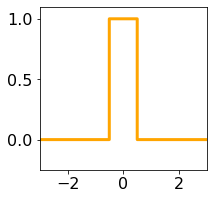

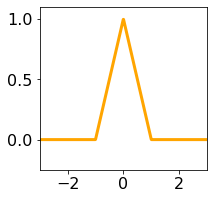

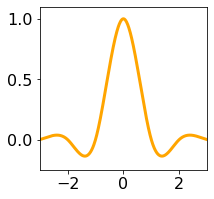

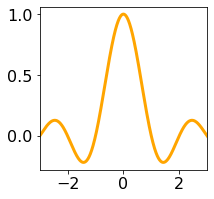

In [8]:
test = np.array([0,0,0,0,0,1,0,0,0,0,0])

plt.figure(figsize=(3,3))
plt.plot(np.linspace(-5, test.size-6, 1000), [interp(test, t, order0) for t in np.linspace(0, test.size-1, 1000)], drawstyle = "steps-pre", color="orange")
plt.xlim(-3,3)
plt.ylim(-0.25, 1.1)
#plt.savefig("order0.pdf",bbox_inches='tight')
plt.show()

plt.figure(figsize=(3,3))
plt.plot(np.linspace(-5, test.size-6, 1000), [interp(test, t, order1) for t in np.linspace(0, test.size-1, 1000)], color="orange")
plt.xlim(-3,3)
plt.ylim(-0.25, 1.1)
#plt.savefig("order1.pdf",bbox_inches='tight')
plt.show()

plt.figure(figsize=(3,3))
plt.plot(np.linspace(-5, test.size-6, 1000), [interp(test, t, order3) for t in np.linspace(0, test.size-1, 1000)], color="orange")
plt.xlim(-3,3)
plt.ylim(-0.25, 1.1)
#plt.savefig("order3.pdf",bbox_inches='tight')
plt.show()

plt.figure(figsize=(3,3))
plt.plot(np.linspace(-5, test.size-6, 1000), [interp(test, t, sinc) for t in np.linspace(0, test.size-1, 1000)], color="orange")
plt.xlim(-3,3)
#plt.savefig("ordersinc.pdf",bbox_inches='tight')
plt.show()

Visually, what happens during interpolation is that we take these impulse responses, and put them on top of each sample, so that the middle top of the impulse response exactly touches the sample point. The impulse responses hence overlay each other and we sum them up together to obtain the interpolated function!

Let's observe this with an arbitrary signal **x** that we define right below.

In [9]:
x = np.array([1, .6, .7, -.3, -.6, 0, .3, -.8, -.4, 0])

The 4 above methods are plotted, as well as 2 more for comparison.

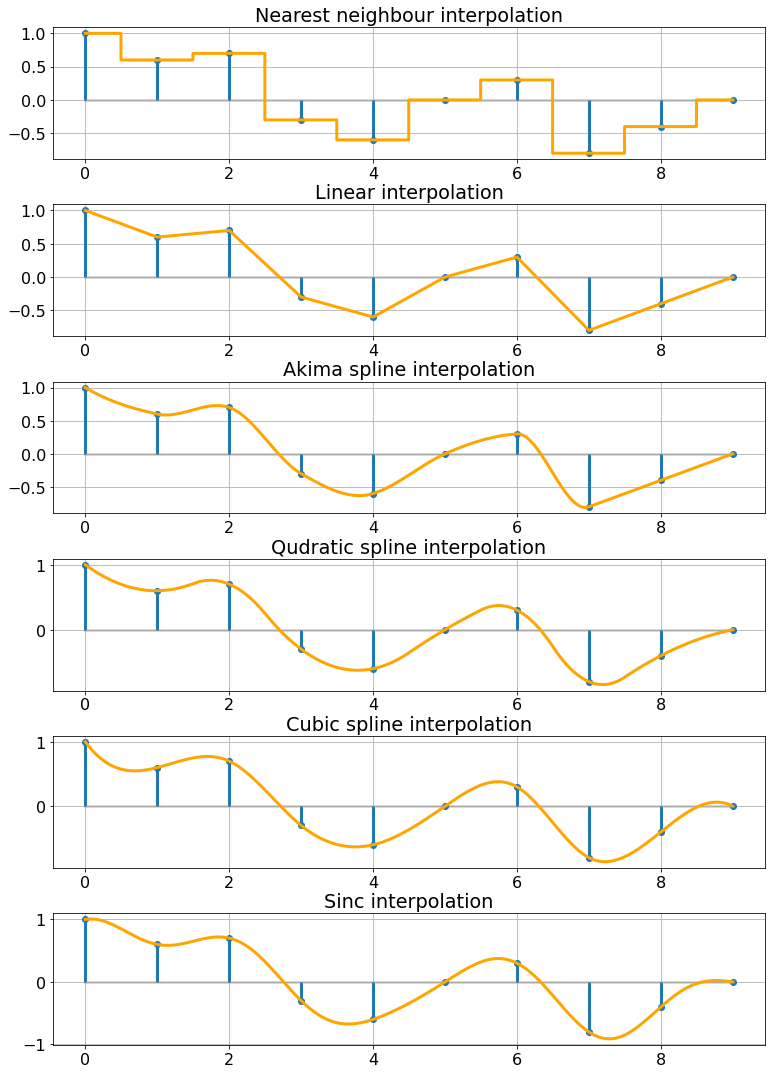

In [10]:
fig, ax = plt.subplots(6, figsize=(11,15))
fig.tight_layout()

for i in range(6):
    ax[i].stem(x, basefmt=" ")
    ax[i].grid(True)
    ax[i].plot(np.linspace(0, x.size-1, 1000), np.zeros(1000), color="gray", alpha=.3)

ax[0].set_title("Nearest neighbour interpolation")
ax[0].plot(np.linspace(0, x.size-1, 1000), [interp(x, t, order0) for t in np.linspace(0, x.size-1, 1000)], drawstyle = "steps-pre", color="orange")

ax[1].set_title("Linear interpolation")
ax[1].plot(np.linspace(0, x.size-1, 1000), [interp(x, t, order1) for t in np.linspace(0, x.size-1, 1000)], color="orange")

ax[2].set_title("Akima spline interpolation")
ax[2].plot(np.linspace(0, x.size-1, 1000), interpolate.Akima1DInterpolator(np.arange(10), x)(np.linspace(0, x.size-1, 1000)) , color="orange")

ax[3].set_title("Qudratic spline interpolation")
ax[3].plot(np.linspace(0, x.size-1, 1000), interpolate.interp1d(np.arange(10), x, kind='quadratic')(np.linspace(0, x.size-1, 1000)) , color="orange")

ax[4].set_title("Cubic spline interpolation")
ax[4].plot(np.linspace(0, x.size-1, 1000), [2*interp(x, t, order3) for t in np.linspace(0, x.size-1, 1000)], color="orange")

ax[5].set_title("Sinc interpolation")
ax[5].plot(np.linspace(0, x.size-1, 1000), [interp(x, t, sinc)   for t in np.linspace(0, x.size-1, 1000)], color="orange")

#plt.savefig("interpolation.pdf",bbox_inches='tight')
plt.show()

We observe that the different techniques becomes smoother and closer to the actual sinc interpolation, but it also comes with a cost. Splines interpolation is quite slow and needs complex arithmetic, hence not really suitable for simple hardware we may find is a CD-player for instance. In practice, mostly linear interpolation is used as it "sounds good enough" as the sampling frequency of 44100Hz often used for audio is fast enough so that the speakers naturally induce a smoothing of the produced signal.

## 2. Quantization

The other step of discretization is the quantization. Given a time-discrete signal $x[n]$ whose amplitudes are real, we define a list of intervals that together exactly cover the entire input range of the signal. Each interval is numbered (generally, a number $2^R$ of intervals is chosen). For each value $x[n]$ of the signal, we associate it with the interval's number it falls in. The resulting signal is called $\hat{x}[n]$ and is a finite list containing the number of the interval of each sample. It introduces distortion in the signal as it "squares" the wave.

## 2.1. Dithering 

One main challenge to tackle when quantizing a signal is quantization noise. In theory, an easy method for reducing the noise created by quantization, and hence to improve the SNR, is to oversample the signal prior to quantization, and to downsample afterwards. In other words, instead of sampling the signal at the desired sampling rate and then to quantize the signal, we sample $N$ times more often than the desired sampling frequency $f_s$. We then quantize all the samples, introducting quantization noise, before averaging $N$ samples together using a lowpass filter, to finally downsample the lowpassed signal $N$ times. 

The trick is that upsampling increases the energy of the signal while compressing it above the origin. However, the intensity of the noise added by quantization is the same with or without upsampling! Adding a lowpass after upsampling discards all the noise generated above the Nyquist frequency, and subsequently downsampling bring back down the energy of the signal, and also brings down the signal of the noise! The final noise has an energy $N$ times smaller than without oversampling, where $N$ is the oversampling factor. Unfortunately, this technique only works if the quantization noise is totally independent of the signal itself, which is in practice **hardly true**. If we sample fast enough to transcribe the signal correctly, subsequent samples will be very similar and hence quite correlated, making oversampling ineffective.

One way to tackle the noise correlation problem is to manually add a quiet white noise to the signal in order to make the noise as independent as possible from any wanted signal. This process is called **dithering**. By adding noise whose width does not exceed the interval size too much, we can randomize the distribution of the samples in the different quantization intervals. The triangular distribution given by the PDF

$$
f(x; a,b,c) = 
\begin{cases}
    0 & \text{for } x < a, \\
    \frac{2(x-a)}{(b-a)(c-a)} & \text{for } a \le x < c, \\[4pt]
    \frac{2}{b-a}             & \text{for } x = c, \\[4pt]
    \frac{2(b-x)}{(b-a)(b-c)} & \text{for } c < x \le b, \\[4pt]
    0 & \text{for } b < x
 \end{cases}
$$

is a popular choice for the dithering noise as it also minimizes noise modulation.

In [11]:
%%capture
from QuantizationNoise import quantize

Let us implement a function that quantizes the signal over $R$ intervals using dithering, and let us compare it with the simple quantization function over $R$ steps without dithering.

In [12]:
def dither_quantize(x, R):
    """
    Quantize a signal x over R intervals using triangular noise dithering.
    """
    width = (1/2**R)**.3

    d = np.random.triangular(left=-width, mode=0, right=width, size=x.size)
    return quantize(x+d, R)

We quantize a simple sine wave using both methods, and subsequently lowpass the quantized signal to simulate playing it through loudspeakers.

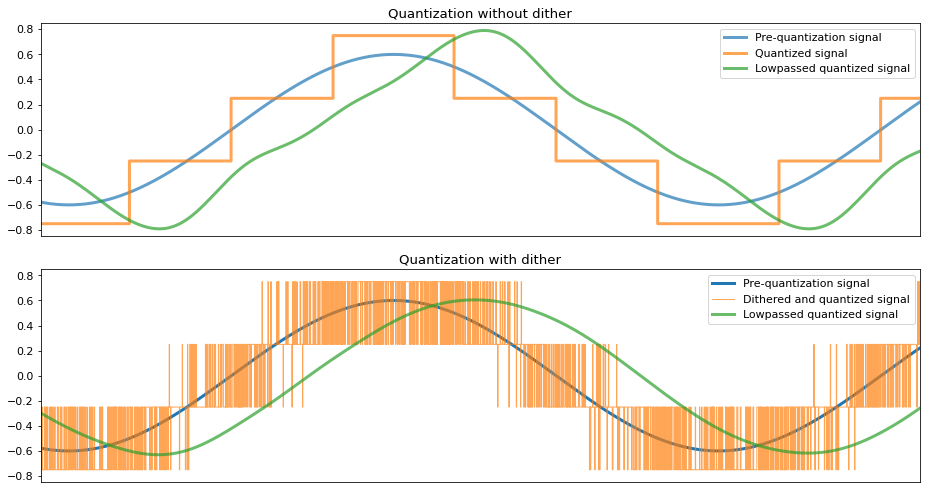

In [13]:
my_sine = sine(.6, 150, 0, np.linspace(0, 1, 44100))
R = 4

fig, ax = plt.subplots(2, figsize=(13,7))
fig.tight_layout()

ax[0].plot(my_sine, label="Pre-quantization signal", alpha=.7)
ax[0].plot(quantize(my_sine, R), label="Quantized signal", drawstyle = "steps-pre", alpha=.7)
ax[0].plot(butter_pass_filter(quantize(my_sine, R), np.array([100]), 44100, "low", order=5), label="Lowpassed quantized signal", alpha=.7)
ax[0].set_title("Quantization without dither")

ax[1].plot(my_sine, label="Pre-quantization signal", alpha=1)
ax[1].plot(dither_quantize(my_sine, R), label="Dithered and quantized signal", drawstyle = "steps-pre", alpha=.7, linewidth=1)
ax[1].plot(butter_pass_filter(dither_quantize(my_sine, R), np.array([100]), 44100, "low", order=5), label="Lowpassed quantized signal" ,alpha=.7)
ax[1].set_title("Quantization with dither")

for i in range(2):
    ax[i].legend(loc="upper right")
    ax[i].set_xlim(5000, 7500)
    ax[i].set_ylim(-.85, .85)
    ax[i].get_xaxis().set_visible(False)

plt.xlabel("Samples")

#plt.savefig("dithering.pdf",bbox_inches='tight')
plt.show()

We see that the dithering leads to a much better signal!! Let us look at what happens in the frequency domain.

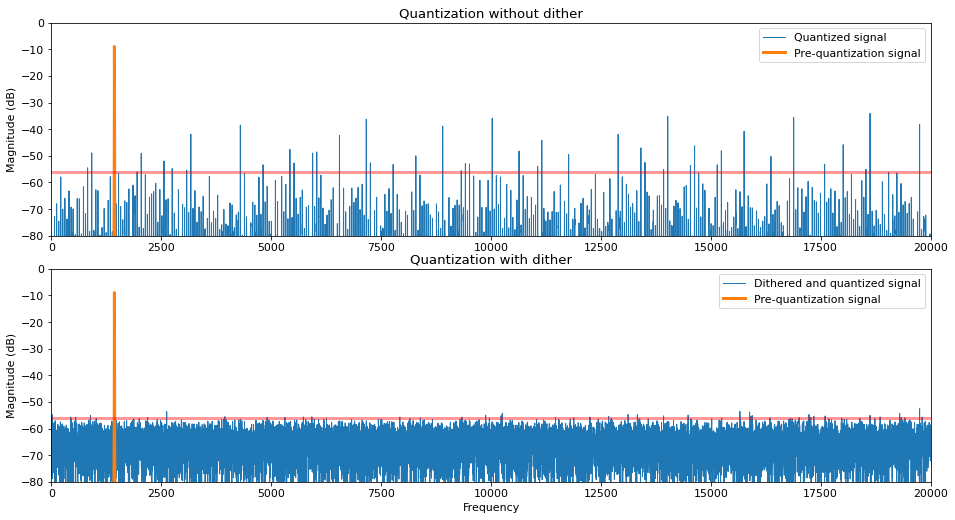

In [14]:
my_sine = sine(.8, 9000, 0, np.linspace(0, 1, 44100))
N = 50
R = 8

fig, ax = plt.subplots(2, figsize=(13, 7))
fig.tight_layout()

ax[0].magnitude_spectrum(quantize(my_sine, R), Fs=44100, scale="dB", linewidth=1, label="Quantized signal")
ax[0].magnitude_spectrum(my_sine, Fs=44100, scale="dB", label="Pre-quantization signal")
ax[0].set_title("Quantization without dither")
ax[0].xaxis.set_label_text("")

ax[1].magnitude_spectrum(dither_quantize(my_sine, R), Fs=44100, scale="dB", linewidth=1, label="Dithered and quantized signal")
ax[1].magnitude_spectrum(my_sine, Fs=44100, scale="dB", label="Pre-quantization signal")
ax[1].set_title("Quantization with dither")

#ax[2].magnitude_spectrum(noise_shaping_quantize(my_sine, R), Fs=44100, scale="dB", label="Dithered and quantized signal")
#ax[2].magnitude_spectrum(my_sine, Fs=44100, scale="dB", label="Pre-quantization signal")
#ax[2].set_title("Quantization with noise shaping")

for i in range(2):
    ax[i].legend(loc="upper right")
    ax[i].set_xlim(0, 20000)
    ax[i].set_ylim(-80, 0)
    ax[i].axhline(-56, color="red", alpha=.4)

#plt.savefig("dithering_noise.pdf",bbox_inches='tight')
plt.show()

While injecting more noise to the signal, dithering also reduces the size of the noise peaks by evening down the noise floor!

Dithering hence offers a trade-off between SNR and quantization distortion. One way to get the best of both words is to upsample the signal prior to dithering, and to store the upsampled version on the computer directly. This way, when converted back to analog for playing, the speaker will naturally apply a lowpass filter on the upsampled signal and hence get rid of the noise by averaging it. Oversampling by a factor $N$ will increase the quantization resolution by only $R_{\text{dith}} = \log_4 N$, making it practically impossible to get rid of the noise AND the quantization error at once.

Let's illustrate the trade-off problem. For instance, let us assume we want to record a guitar with an audio interface having 32bits of quantization precision. We want to store the guitar on a CD using only 16bits quantization. In order to keep a virtual quantization of 32 bits, we need the dithering+oversampling method to make up for 16 lost bits. According to the equation above, this means that we need to oversample by a factor $N = 2^{32}$, clearly infeasible in practice! Dither noise is hence not removable, but can be very handy when a not too large number of quantization bits has to be discarded.

## 3. Delta-sigma modulation

Delta-sigma modulation is a more advanced technique for converting a signal from analog to digital and back. The main concept that lies behind delta-sigma is to encode all the data using pulse-density modulation (PDM), a storing method where only 1 bit is used for quantization, similarly to what happened with dithering, but over the whole amplitude range at once. But why 1-bit?

- it allows a lower noise by storing pulses (PDM, see below) encoding the difference between the samples, rather than the samples themselves
- 1-bit streams, being highly oversampled, are easy to convert to analog, since they require just a simple lowpass filter (just like in the dithering example above). As a matter of fact, the D/A's in smartphones, tablets and PCs all use 1-bit conversion prior to analog interpolation
- 1-bit streams are easy to transmit over links such as USB and fiber optics, since they require no reframing
- very efficient hardware exists to convert PCM data into 1-bit data and vice-versa.

The naive way to convert a signal to 1-bit would be to simply quantize it over one bit, although it is not hard to understand while this is not a good idea. Quantizing over one bit boils down to simply keep the sign of the signal for each sample, hence discarding a lot of information, and introducing heavy distortion.

Pulse-code modulation (PCM) is the most straight-forward way to encode a signal digitally. As a matter of fact, all the methods described above encode analog signals into a PCM digital version. PCM uses two parameters:

- the **sampling frequency** $f_s$, that defines how many times per second the analog signal's amplitude is being measured (that is, how many samples per second are taken)
- the **bit depth** $R$, that defines how many bits are used for encoding each sample. The amplitude can be encoded is different ways over these bits (floating point, linearly, ...) but the number of bits is fixed according to the number of quantization intervals.

PCM is used in file formats such as .wav. One of the main disadvantages of PCM is that all noise in the system is added to the analog signal when interpolating, reducing its quality. 

Pulse-density modulation (PDM) instead stores the difference between the samples, and encodes them using 1-bit. It generates a non-periodic two-level signal whose local average tracks the local average of the input analog signal. In order to capture enough bandwidth in the original signal, a very fast sampling frequency must be used. This is what is produced by a delta-sigma modulator. It hence uses only one parameter:

- the **sampling frequency** $f_s$, that defines how many times per second the analog signal's amplitude difference is being measured, before being quantized to 1 bit. Typically, $f_s$ is 16 to 64 times faster than the equivalent PCM encoded signal's sampling frequency.

In [15]:
%%capture
from OneBitMusic import sigma_delta, sigma_delta2

The first-order delta-sigma circuit is

![sigma delta](./pictures/sigmadelta.png)

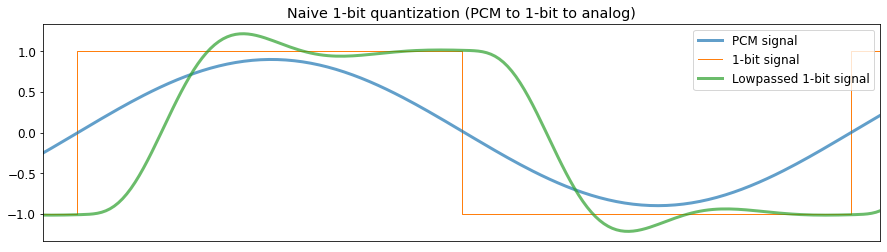

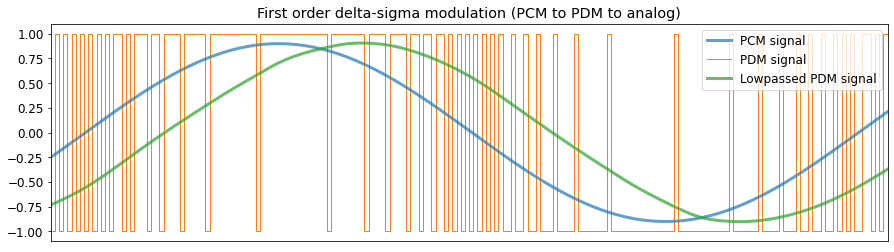

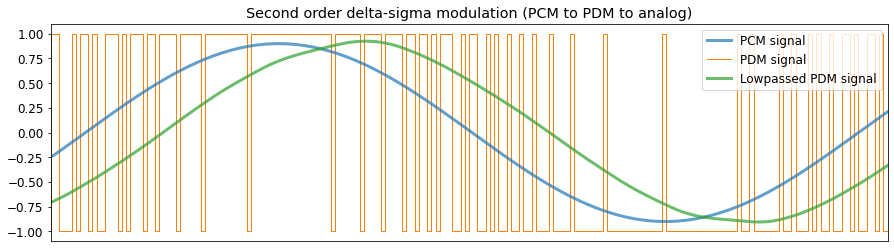

In [16]:
my_sine = sine(.9, 1500, 0, np.linspace(0, 1, 44100))
ds_order = 3

plt.figure(figsize=(15,4))

plt.plot(my_sine, alpha=.7, label="PCM signal")
plt.plot(np.sign(my_sine), alpha=1, zorder=-2, linewidth=1,  drawstyle = "steps", label="1-bit signal")
#plt.plot(moving_average(sigma_delta(my_sine), 40), alpha=.7, label="Averaged quantized signal")
plt.plot( butter_pass_filter(np.sign(my_sine), np.array([1000]), 44100, "low", order=4), 
         alpha=.7, 
         label="Lowpassed 1-bit signal")

plt.xlim(1100, 1300)
plt.legend(loc="upper right")
plt.xlabel("Samples")
plt.title("Naive 1-bit quantization (PCM to 1-bit to analog)")

plt.gca().axes.get_xaxis().set_visible(False)
#plt.savefig("1-bit.pdf", bbox_inches='tight')
plt.show()


plt.figure(figsize=(15,4))

plt.plot(my_sine, alpha=.7, label="PCM signal")
plt.plot(sigma_delta(my_sine), alpha=1, zorder=-2, linewidth=1,  drawstyle = "steps", label="PDM signal")
#plt.plot(moving_average(sigma_delta(my_sine), 40), alpha=.7, label="Averaged quantized signal")
plt.plot( butter_pass_filter(sigma_delta(my_sine), np.array([1000]), 44100, "low", order=4), 
         alpha=.7, 
         label="Lowpassed PDM signal")

plt.xlim(1100, 1300)
plt.legend(loc="upper right")
plt.xlabel("Samples")
plt.title("First order delta-sigma modulation (PCM to PDM to analog)")

plt.gca().axes.get_xaxis().set_visible(False)
#plt.savefig("delta_sigma.pdf", bbox_inches='tight')
plt.show()


plt.figure(figsize=(15,4))

plt.plot(my_sine, alpha=.7, label="PCM signal")
plt.plot(sigma_delta2(my_sine), alpha=1, zorder=-2, linewidth=1,  drawstyle = "steps", label="PDM signal")
#plt.plot(moving_average(sigma_delta(my_sine), 40), alpha=.7, label="Averaged quantized signal")
plt.plot( butter_pass_filter(sigma_delta2(my_sine), np.array([1000]), 44100, "low", order=4), 
         alpha=.7, 
         label="Lowpassed PDM signal")

plt.xlim(1100, 1300)
plt.legend(loc="upper right")
plt.xlabel("Samples")
plt.title("Second order delta-sigma modulation (PCM to PDM to analog)")

plt.gca().axes.get_xaxis().set_visible(False)
#plt.savefig("delta_sigma2.pdf", bbox_inches='tight')
plt.show()

We observe that the PDM signal's local frequency increases when the PCM signal has a low amplitude, whereas the PDM is almost constant when the PCM signal has a high amplitude. The lowpassed analog signal is quite similar to the PCM signal, making the delta-sigma a reliable modulation method when the PDM sampling frequency is fast enough. A short delay is introduced by the lowpass filter, but poses no problem in practice.

### 3.1 Noise shaping

An alternative way of understanding the advantage of PDM over 1-bit quantization can be observed in the frequency domain. As seen above, quantization introduces a lot of quantization noise in the signal, even when oversampling is used. Quantizing naively over 1-bit suffers from that problem at the maximum. Delta-sigma modulation, by generating a rapidly alternating PDM signal, tends to put more noise energy into high frequencies of the PDM signal than naive 1-bit quantization does. By oversampling the signal sufficiently prior to using delta-sigma, the noise hence concentrates in the high frequencies of the oversampled signal, i.e. the frequencies above the Nyquist frequency, that will get discarded after downsampling. 

The action of putting the noise energy in the discarded high frequencies is called **noise shaping**. Let us try it out below!

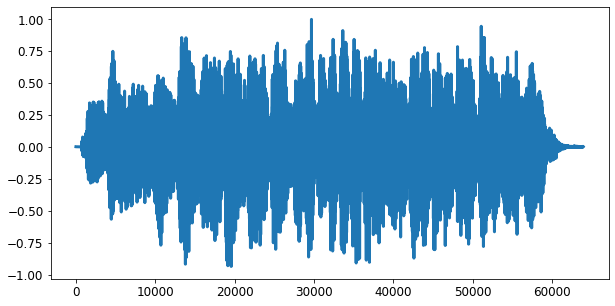

In [17]:
s8 = open_audio('./samples/brand1.wav')
Audio(s8, rate=8000)

Let us now apply a delta-sigma modulation to the *upsampled* signal. Since the Nyquist frequency is only 4000Hz, we will hear noise above the Nyquist frequency, but we can easily filter it out when playing back.

In [18]:
s8_oversampled = oversample(s8)

s8_ds = sigma_delta(s8_oversampled)
Audio(s8_ds, rate=8*8000)

This high frequency noise is the effect of noise sampling, that put most of the noise energy in the frequencies above the Nyquiest frequency! Let us compare graphically the effect of noise shaping on the signal's frequencies.

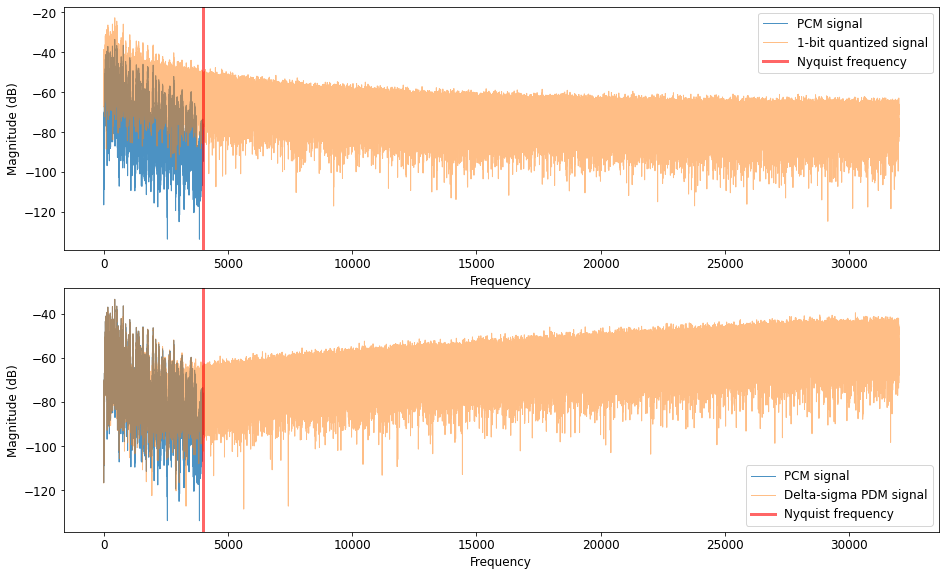

In [19]:
fig, ax = plt.subplots(2, figsize=(13, 8))
fig.tight_layout()

ax[0].magnitude_spectrum(s8, Fs=8000, scale="dB", linewidth=1, alpha=.8, label="PCM signal")
#plt.magnitude_spectrum(s8_oversampled, Fs=64000, scale="dB", linewidth=.1, alpha=.6, label="8x oversampled PCM signal")
ax[0].magnitude_spectrum(np.sign(s8_oversampled), Fs=64000, scale="dB", linewidth=1, alpha=.5, label="1-bit quantized signal")
#ax[0].magnitude_spectrum(s8_ds, Fs=64000, scale="dB", linewidth=1, alpha=.5,label="Delta-sigma PDM signal")
#plt.magnitude_spectrum(s8_ds2, Fs=64000, scale="dB", linewidth=1, alpha=.5, label="Delta-sigma (order 2) PDM signal")
ax[0].axvline(4000, label="Nyquist frequency", color="red", alpha=.6)

ax[1].magnitude_spectrum(s8, Fs=8000, scale="dB", linewidth=1, alpha=.8, label="PCM signal")
#plt.magnitude_spectrum(s8_oversampled, Fs=64000, scale="dB", linewidth=.1, alpha=.6, label="8x oversampled PCM signal")
#ax[0].magnitude_spectrum(np.sign(s8_oversampled), Fs=64000, scale="dB", linewidth=1, alpha=.5, label="1-bit quantized signal")
ax[1].magnitude_spectrum(s8_ds, Fs=64000, scale="dB", linewidth=1, alpha=.5,label="Delta-sigma PDM signal")
#plt.magnitude_spectrum(s8_ds2, Fs=64000, scale="dB", linewidth=1, alpha=.5, label="Delta-sigma (order 2) PDM signal")
ax[1].axvline(4000, label="Nyquist frequency", color="red", alpha=.6)

ax[0].legend(loc="upper right")
ax[1].legend(loc="lower right")
#plt.savefig("noise_shaping.pdf", bbox_inches='tight')
plt.show();

In the simple 1-bit quantization, the signal below the Nyquist frequency is quite different from the original. On the delta-sigma modulated one, the audible signal is preserved! Most of the noise has been pushed on the right in the frequencies to be discarded after lowpassing!